In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
import numpy as np
from astropy.table import QTable
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.visualization import astropy_mpl_style
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')
plt.style.use(astropy_mpl_style)

In [12]:
from astroquery.gaia import Gaia
from astropy.table import QTable

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [24]:
#pulling new data from Gaia DR2
job = Gaia.launch_job_async("""SELECT source_id,ra,dec,parallax,parallax_error,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radial_velocity,radial_velocity_error,l,b,teff_val
        FROM gaiadr2.gaia_source 
        WHERE parallax >=3.33333333 AND phot_g_mean_mag < 11 AND parallax_error < 0.1 AND radial_velocity_error < 0.5""" \
                           , dump_to_file=True)
print(job)

Jobid: 1531017484688O
Phase: COMPLETED
Owner: None
Output file: async_20180707193802.vot
Results: None


In [2]:
#reading in data file pulled from Gaia archive

gaiatable = QTable.read('async_20180707193105.vot', format='votable')
#print(gaiatable)

In [3]:
#establishing variables from column names
ra_gaia = gaiatable['ra']
dec_gaia = gaiatable['dec']
plx = gaiatable['parallax']
gmag = gaiatable['phot_g_mean_mag']
pmra = gaiatable['pmra']
pmdec = gaiatable['pmdec']
bpmag = gaiatable['phot_bp_mean_mag']
rpmag = gaiatable['phot_rp_mean_mag']
radvel = gaiatable['radial_velocity']
teff = gaiatable['teff_val']
galong = gaiatable['l']
galat = gaiatable['b']

In [6]:
#inputting variables into a coordinates object for future manipulation

c1 = coord.ICRS(ra=ra_gaia, dec=dec_gaia,
                distance=(plx).to(u.pc, u.parallax()),
                pm_ra_cosdec=(pmra.value*np.cos(pmdec.value))*u.mas/u.yr,
                pm_dec=(pmdec.value)*u.mas/u.yr,
                radial_velocity=(radvel.value)*u.km/u.s
               )

In [7]:
#transforming coordinates from reference frame given in Gaia DR2 to galactocentric frame

gc1 = c1.transform_to(coord.Galactocentric)
galv_x = gc1.v_x
galv_y = gc1.v_y
galv_z = gc1.v_z
print(gc1.v_x, gc1.v_y, gc1.v_z)

[-30.13461742 105.10362678 -19.85170679 ...  34.93790285 -64.14243651
  18.50847095] km / s [194.7287312  186.59563307 206.15900707 ... 217.32363827 314.52592032
 221.10770403] km / s [ 13.62077513 -27.14382102  -7.53799453 ...  -9.19636184 -53.26716284
 -13.52608876] km / s


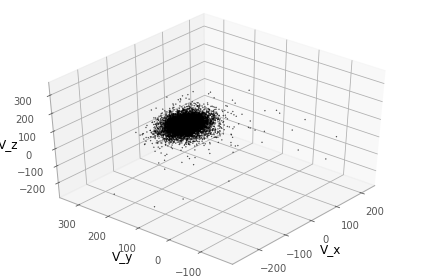

In [66]:
#making a 3D plot of galactocentric velocities

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

fig.tight_layout()

ax.set_xlabel("V_x")
ax.set_ylabel("V_y")
ax.set_zlabel("V_z")

ax.scatter(galv_x, galv_y, galv_z, c = 'k', s=0.1, alpha=1);
ax.view_init(azim = -140, elev = 40);

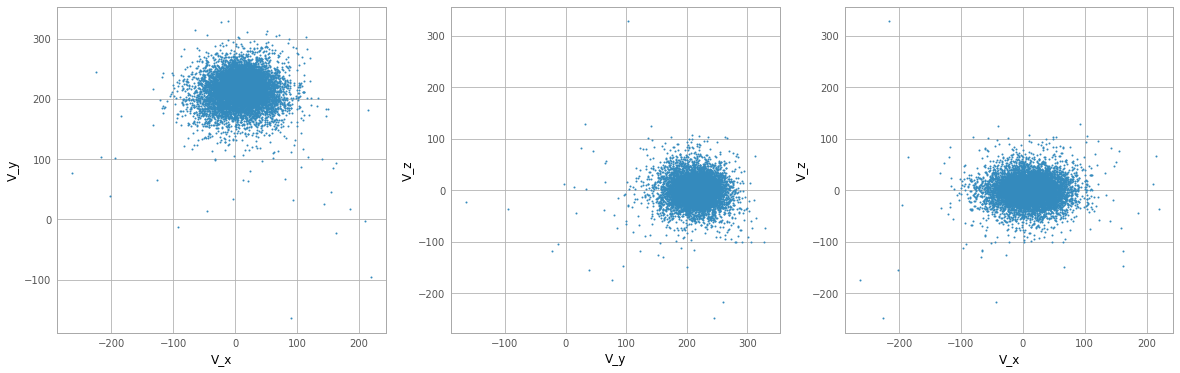

In [67]:
#the same plot as above but in 2D

fig, ax = plt.subplots(1,3);
fig.set_size_inches(20,6)


ax[0].set_xlabel("V_x")
ax[0].set_ylabel("V_y")

ax[1].set_xlabel("V_y")
ax[1].set_ylabel("V_z")

ax[2].set_xlabel("V_x")
ax[2].set_ylabel("V_z")

ax[0].scatter(galv_x, galv_y, s=1);
ax[1].scatter(galv_y, galv_z, s=1);
ax[2].scatter(galv_x, galv_z, s=1);

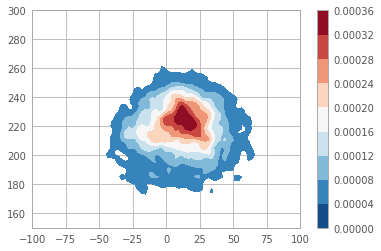

In [70]:
#kernel density estimate plot for the x and y components of galactocentric velocities

sns.kdeplot(galv_x.value, galv_y.value, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.ylim([150,300])
plt.xlim([-100,100])
plt.show()

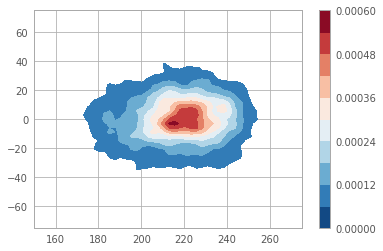

In [21]:
#kernel density estimate plot for the y and z components of galactocentric velocities

sns.kdeplot(galv_y.value, galv_z.value, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.xlim([150,275])
plt.ylim([-75,75])
plt.show()

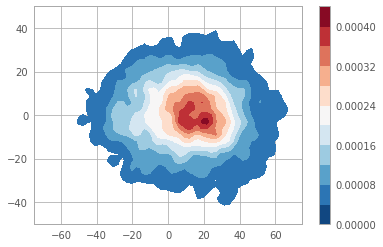

In [22]:
#kernel density estimate plot for the x and z components of galactocentric velocities

sns.kdeplot(galv_x.value, galv_z.value, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.ylim([-50,50])
plt.xlim([-75,75])
plt.show()

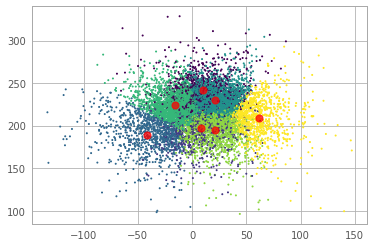

In [13]:
#prepping kmeans, making a mask to remove outliers and focus on main cluster of sources,
# plotting kmeans for x and y components of galactocentric velocities

mask = np.where((galv_x.value < 150) & (galv_x.value > -150) & (galv_y.value < 500)
                & (galv_y.value > 90) & (galv_z.value < 600) & (galv_z.value > -125))

xmasked = galv_x[mask]
ymasked = galv_y[mask]
zmasked = galv_z[mask]

fullarray = np.array([galv_x, galv_y, galv_z]).T
vsarray = np.array([xmasked, ymasked, zmasked]).T

kmeans = KMeans(n_clusters=7)
kmeans.fit(vsarray)
y_kmeans = kmeans.predict(vsarray)

plt.scatter(vsarray[:, 0], vsarray[:, 1], c=y_kmeans, s=1, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.75);

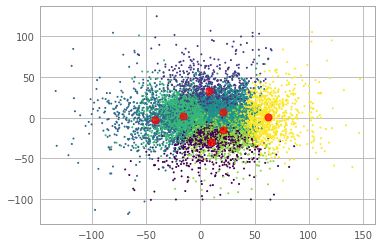

In [14]:
#plotting kmeans for x and z components of galactocentric velocities

plt.scatter(vsarray[:, 0], vsarray[:, 2], c=y_kmeans, s=1, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='red', s=50, alpha=0.75);

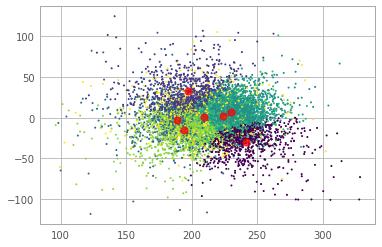

In [15]:
# plotting kmeans for y and z components of galactocentric velocities

plt.scatter(vsarray[:, 1], vsarray[:, 2], c=y_kmeans, s=1, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], c='red', s=50, alpha=0.75);

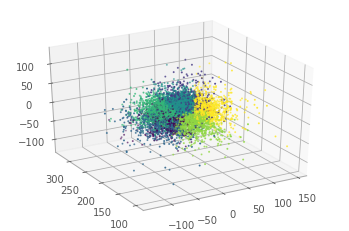

In [20]:
#A 3D plot of the three above 2D plots, unsure if centers are not visible because of coding error or just visual obstruction

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

ax.scatter(vsarray[:, 0], vsarray[:, 1], vsarray[:, 2], c=y_kmeans, s=1, cmap='viridis')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=50, alpha=0.75);

ax.view_init(azim = -120, elev = 30);